In [14]:
import numpy as np
from tf_agents.environments import suite_gym

env = suite_gym.load("SpaceInvaders-v4")
env.step(1).observation.shape

/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


(210, 160, 3)

In [4]:
env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [7]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000
environment_name = "SpaceInvadersNoFrameskip-v4"

# ?
# class AtariPreprocessingWithAutoFire(AtariPreprocessing):
#     def reset(self, **kwargs):
#         obs = super().reset(**kwargs)
#         super().step(1) # FIRE to start
#         return obs
#     def step(self, action):
#         lives_before_action = self.ale.lives()
#         obs, rewards, done, info = super().step(action)
#         if self.ale.lives() < lives_before_action and not done:
#             super().step(1) # FIRE to start after life lost
#         return obs, rewards, done, info

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])
env

In [8]:
env.seed(42)
env.reset()
for _ in range(4):
    time_step = env.step(3) # LEFT
    print(time_step.observation.shape)

(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)


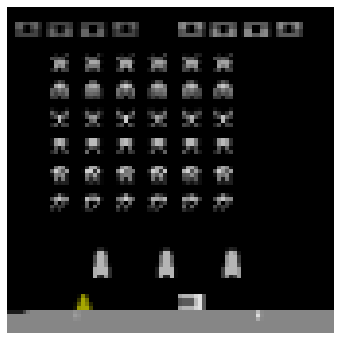

In [16]:
import matplotlib.pyplot as plt

def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
plt.show()